## Photometric Stereo, Specularity Removal 

The goal of this program is to implement a couple of different algorithms that reconstruct a surface using the concept of photometric stereo.

Additionally, you will implement the specular removal technique of Mallick et al., which enables photometric stereo reconstruction of certain non-Lambertian materials. 

### Data
Synthetic Images, Specular Sphere Images, Pear Images for Part 1, 2, 3: Available in `*.pickle` files (graciously provided by Satya Mallick) which contain

* `im1`, `im2`, `im3`, `im4`... images.

* `l1`, `l2`, `l3`, `l4`... light source directions.

* `c` (when required) color of light source.

### Part 1:

Implement the photometric stereo technique described in Forsyth and Ponce 2.2.4 (*Photometric Stereo: Shape from Multiple Shaded Images*). 

The program should have two parts:

1. Read in the images and corresponding light source directions, and estimate the surface normals and albedo map.

1. Reconstruct the depth map from the surface normals. You can first try the naive scanline-based shape by integration method described in the book.  If this does not work well on real images, you can use the implementation of the Horn integration technique given below in `horn_integrate` function.

For each of the above cases the program outputs:

1. The estimated albedo map.

1. The estimated surface normals by showing both
    1. Needle map, and
    1. Three images showing components of surface normal.

1. A wireframe of depth map.


Keys: dict_keys(['__version__', 'l4', '__header__', 'im1', 'im3', 'im2', 'l2', 'im4', 'l1', '__globals__', 'l3'])
Image:


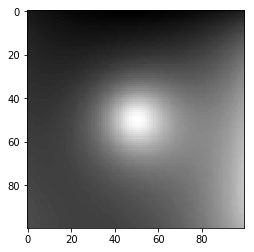

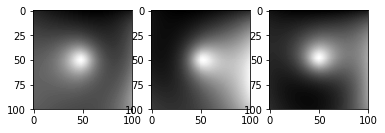

Light source direction: [[0 0 1]]
Light source direction: [[0.2 0.  1. ]]
Light source direction: [[-0.2  0.   1. ]]
Light source direction: [[0.  0.2 1. ]]


In [664]:
## Example: How to read and access data from a pickle
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
pickle_in = open("synthetic_data.pickle", "rb")
# data = pickle.load(pickle_in)
data = pickle.load(pickle_in, encoding="latin1")

# data is a dict which stores each element as a key-value pair. 
print("Keys: " + str(data.keys()))

# To access the value of an entity, refer it by its key.
print("Image:")
plt.imshow(data["im1"], cmap = "gray")
plt.show()
for i in range(3):
    plt.subplot(131+i)
    plt.imshow(data["im"+str(2+i)], cmap = "gray")
plt.show()

print("Light source direction: " + str(data["l1"]))
print("Light source direction: " + str(data["l2"]))
print("Light source direction: " + str(data["l3"]))
print("Light source direction: " + str(data["l4"]))

In [476]:
import numpy as np
from scipy.signal import convolve
from numpy import linalg

def horn_integrate(gx, gy, mask, niter):
    '''
    horn_integrate recovers the function g from its partial 
    derivatives gx and gy. 
    mask is a binary image which tells which pixels are 
    involved in integration. 
    niter is the number of iterations. 
    typically 100,000 or 200,000, 
    although the trend can be seen even after 1000 iterations.
    '''    
    g = np.ones(np.shape(gx))
    
    gx = np.multiply(gx, mask)
    gy = np.multiply(gy, mask)
    
    A = np.array([[0,1,0],[0,0,0],[0,0,0]]) #y-1
    B = np.array([[0,0,0],[1,0,0],[0,0,0]]) #x-1
    C = np.array([[0,0,0],[0,0,1],[0,0,0]]) #x+1
    D = np.array([[0,0,0],[0,0,0],[0,1,0]]) #y+1
    
    d_mask = A + B + C + D
    
    den = np.multiply(convolve(mask,d_mask,mode="same"),mask)
    den[den == 0] = 1
    rden = 1.0 / den
    mask2 = np.multiply(rden, mask)
    
    m_a = convolve(mask, A, mode="same")
    m_b = convolve(mask, B, mode="same")
    m_c = convolve(mask, C, mode="same")
    m_d = convolve(mask, D, mode="same")
    
    term_right = np.multiply(m_c, gx) + np.multiply(m_d, gy)
    t_a = -1.0 * convolve(gx, B, mode="same")
    t_b = -1.0 * convolve(gy, A, mode="same")
    term_right = term_right + t_a + t_b
    term_right = np.multiply(mask2, term_right)
    
    for k in range(niter):
        g = np.multiply(mask2, convolve(g, d_mask, mode="same")) + term_right
    
    return g

In [690]:
def photometric_stereo(images, lights, mask):
    '''
    your implementaion
    '''
    
    xlen = images[0].shape[0]
    ylen = images[0].shape[1]
    
    b = np.zeros((xlen,ylen,3))
    s = np.matrix(lights)
    for x in range(xlen):
        for y in range(ylen):
            tmp = np.linalg.inv(s.T * s) * s.T * np.matrix([ [i[x][y]] for i in images])
            b[x][y] = [tmp[i,0] for i in range(3)]
    
    normals = np.zeros((xlen,ylen,3))
    albedo = np.linalg.norm(b, axis=2)
    for x in range(xlen):
        for y in range(ylen):
            normals[x][y] = b[x][y]/albedo[x][y]
    gx = np.zeros((xlen, ylen))
    gy = np.zeros((xlen, ylen))
    for x in range(xlen):
        for y in range(ylen):
            gx[x][y] = normals[x][y][0]/normals[x][y][2]
            gy[x][y] = normals[x][y][1]/normals[x][y][2]
    H = np.zeros((xlen, ylen))
    for x in range(1,xlen):
        H[x][0] = H[x-1][0] + gy[x][0]
    for x in range(xlen):
        for y in range(1,ylen):
            H[x][y] = H[x][y-1] + gx[x][y]
    H_horn =  horn_integrate(gx, gy, mask, 10000)        
    return albedo, normals, H, H_horn

/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


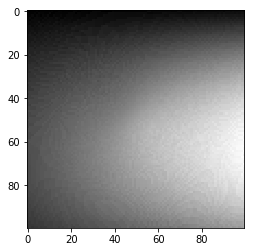

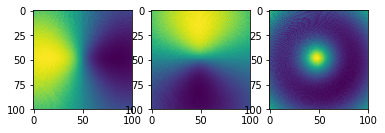

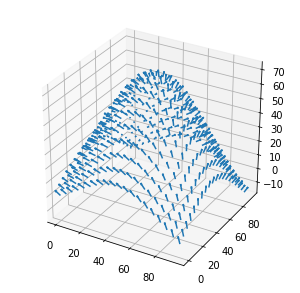

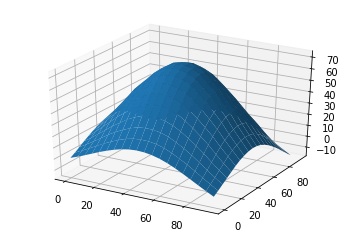

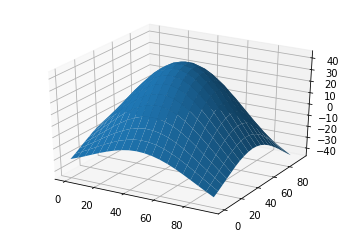

In [699]:
from mpl_toolkits.mplot3d import Axes3D

pickle_in = open("synthetic_data.pickle", "rb")
# data = pickle.load(pickle_in)
data = pickle.load(pickle_in, encoding="latin1")

lights = np.vstack((data["l1"], data["l2"], data["l4"]))
#lights = np.vstack((data["l1"], data["l2"], data["l3"], data["l4"]))

images = []
images.append(data["im1"])
images.append(data["im2"])
#images.append(data["im3"])
images.append(data["im4"])
images = np.array(images)

mask = np.ones(data["im1"].shape)

albedo, normals, depth, horn = photometric_stereo(images, lights, mask)

# --------------------------------------------------------------------------
# Following code is just a working example so you don't get stuck with any
# of the graphs required. You may want to write your own code to align the
# results in a better layout.
# --------------------------------------------------------------------------

# Stride in the plot, you may want to adjust it to different images
stride = 5

# showing albedo map
fig = plt.figure()
albedo_max = albedo.max()
albedo = albedo / albedo_max
plt.imshow(albedo, cmap="gray")
plt.show()

# showing normals as three separate channels
figure = plt.figure()
ax1 = figure.add_subplot(131)
ax1.imshow(normals[..., 0])
ax2 = figure.add_subplot(132)
ax2.imshow(normals[..., 1])
ax3 = figure.add_subplot(133)
ax3.imshow(normals[..., 2])
plt.show()

# showing normals as quiver
X, Y, _ = np.meshgrid(np.arange(0,np.shape(normals)[0], stride),
                      np.arange(0,np.shape(normals)[1], stride),
                      np.arange(1))
X = X[..., 0]
Y = Y[..., 0]
Z = depth[::stride,::stride].T
NX = normals[..., 0][::stride,::-stride].T
NY = normals[..., 1][::-stride,::stride].T
NZ = normals[..., 2][::stride,::stride].T
fig = plt.figure(figsize=(5, 5))
ax = fig.gca(projection='3d')
# plt.quiver(X,Y,Z,NX,NY,NZ, length=0.02)
plt.quiver(X,Y,Z,NX,NY,NZ, length=5)
plt.show()

# plotting wireframe depth map
H = depth[::stride,::stride]
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X,Y, H.T)
plt.show()

H = horn[::stride,::stride]
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X,Y, H.T)
plt.show()

/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


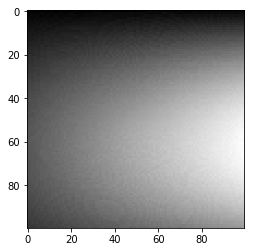

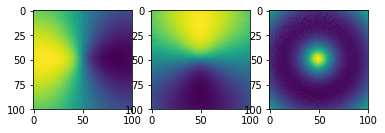

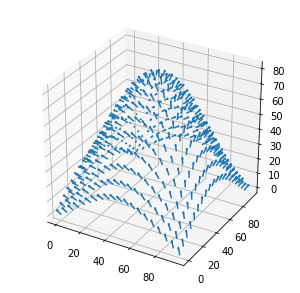

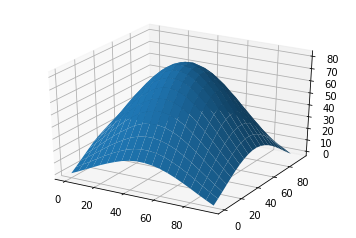

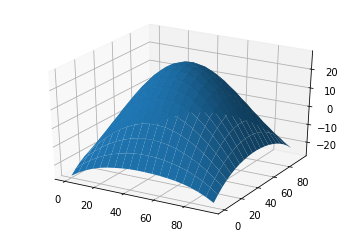

In [679]:
from mpl_toolkits.mplot3d import Axes3D

pickle_in = open("synthetic_data.pickle", "rb")
# data = pickle.load(pickle_in)
data = pickle.load(pickle_in, encoding="latin1")

#lights = np.vstack((data["l1"], data["l2"], data["l4"]))
lights = np.vstack((data["l1"], data["l2"], data["l3"], data["l4"]))

images = []
images.append(data["im1"])
images.append(data["im2"])
images.append(data["im3"])
images.append(data["im4"])
images = np.array(images)

mask = np.ones(data["im1"].shape)

albedo, normals, depth, horn = photometric_stereo(images, lights, mask)

# --------------------------------------------------------------------------
# Following code is just a working example so you don't get stuck with any
# of the graphs required. You may want to write your own code to align the
# results in a better layout.
# --------------------------------------------------------------------------

# Stride in the plot, you may want to adjust it to different images
stride = 5

# showing albedo map
fig = plt.figure()
albedo_max = albedo.max()
albedo = albedo / albedo_max
plt.imshow(albedo, cmap="gray")
plt.show()

# showing normals as three separate channels
figure = plt.figure()
ax1 = figure.add_subplot(131)
ax1.imshow(normals[..., 0])
ax2 = figure.add_subplot(132)
ax2.imshow(normals[..., 1])
ax3 = figure.add_subplot(133)
ax3.imshow(normals[..., 2])
plt.show()

# showing normals as quiver
X, Y, _ = np.meshgrid(np.arange(0,np.shape(normals)[0], stride),
                      np.arange(0,np.shape(normals)[1], stride),
                      np.arange(1))
X = X[..., 0]
Y = Y[..., 0]
Z = depth[::stride,::stride].T
NX = normals[..., 0][::stride,::-stride].T
NY = normals[..., 1][::-stride,::stride].T
NZ = normals[..., 2][::stride,::stride].T
fig = plt.figure(figsize=(5, 5))
ax = fig.gca(projection='3d')
# plt.quiver(X,Y,Z,NX,NY,NZ, length=0.02)
plt.quiver(X,Y,Z,NX,NY,NZ, length=5)
plt.show()

# plotting wireframe depth map
H = depth[::stride,::stride]
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X,Y, H.T)
plt.show()

H = horn[::stride,::stride]
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X,Y, H.T)
plt.show()

### Part 2:
Implement the specularity removal technique described in *Beyond Lambert: Reconstructing Specular Surfaces Using Color* (by Mallick, Zickler, Kriegman, and Belhumeur; CVPR 2005).  

The program should inputs an RGB image and light source color and outputs the corresponding SUV image.  

For each specular sphere and pear images, the program includes

1. The original image (in RGB colorspace).

1. The recovered $S$ channel of the image.

1. The recovered diffuse part of the image - Use $G = \sqrt{U^2+V^2}$ to represent the diffuse part.


In [487]:
def get_rot_mat(rot_v, unit=None):
    '''
    Takes a vector and returns the rotation matrix required to align the
    unit vector(2nd arg) to it.
    '''
    if unit is None:
        unit = [1.0, 0.0, 0.0]
    
    rot_v = rot_v/np.linalg.norm(rot_v)
    uvw = np.cross(rot_v, unit) #axis of rotation

    rcos = np.dot(rot_v, unit) #cos by dot product
    rsin = np.linalg.norm(uvw) #sin by magnitude of cross product

    #normalize and unpack axis
    if not np.isclose(rsin, 0):
        uvw = uvw/rsin
    u, v, w = uvw

    # Compute rotation matrix 
    R = (
        rcos * np.eye(3) +
        rsin * np.array([
            [ 0, -w,  v],
            [ w,  0, -u],
            [-v,  u,  0]
        ]) +
        (1.0 - rcos) * uvw[:,None] * uvw[None,:]
    )
    
    return R

def RGBToSUV(I_rgb, rot_vec):
    '''
    your implementation which takes an RGB image and a vector encoding
    the orientation of S channel wrt to RGB
    '''
    S = np.ones(I_rgb.shape[:2])
    G = np.ones(I_rgb.shape[:2])
    rot_mat = get_rot_mat(rot_vec)
    for i in range(I_rgb.shape[0]):
        for j in range(I_rgb.shape[1]):
            tmp = rot_mat * np.matrix(I_rgb[i,j]).T
            S[i,j] = tmp[0]
            G[i,j] = np.linalg.norm(tmp[1:])
    return S, G

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


c: [[0.6257]
 [0.5678]
 [0.5349]]
Keys: dict_keys(['l4', 'c', '__header__', '__globals__', 'im1', 'im3', 'im2', 'l2', 'im4', 'l1', '__version__', 'l3'])
Image1:
Light source direction: [[-0.38359  -0.236647  0.892668]]


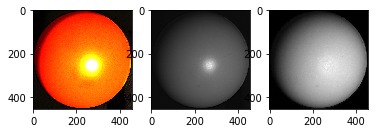

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image2:
Light source direction: [[-0.372825  0.303914  0.87672 ]]


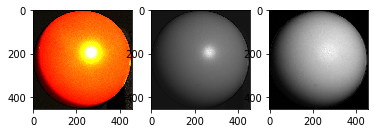

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image3:
Light source direction: [[0.250814 0.34752  0.903505]]


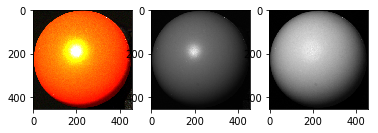

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image4:
Light source direction: [[ 0.203844 -0.096308  0.974255]]


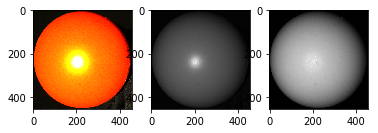

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


c: [[0.6257]
 [0.5678]
 [0.5349]]
Keys: dict_keys(['l4', 'c', '__header__', '__globals__', 'im1', 'im3', 'im2', 'l2', 'im4', 'l1', '__version__', 'l3'])
Image1:
Light source direction: [[-0.342463 -0.263317  0.901877]]


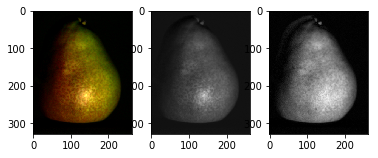

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image2:
Light source direction: [[-0.350453  0.29889   0.887608]]


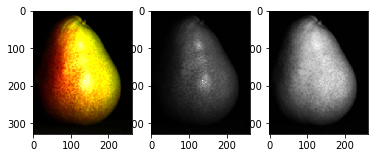

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image3:
Light source direction: [[0.27204  0.337208 0.901268]]


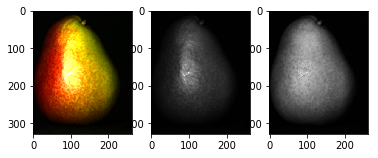

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image4:
Light source direction: [[ 0.229382 -0.10682   0.967457]]


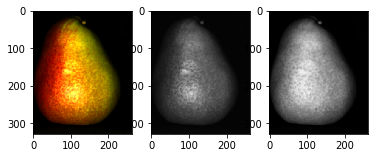

In [676]:

def show_images(data):
    rot_vec = np.hstack((data["c"][0][0],
                         data["c"][1][0],
                         data["c"][2][0]))
    print("c:",data["c"])
    print("Keys: " + str(data.keys()))
    
    for i in range(1,5):
        print("Image"+str(i)+":")
        print("Light source direction: " + str(data["l"+str(i)]))        
        plt.subplot(131)
        plt.imshow(data["im"+str(i)]*255)
        S, G = RGBToSUV(data["im"+str(i)], rot_vec)
        plt.subplot(132)
        plt.imshow(S, cmap='gray')
        plt.subplot(133)
        plt.imshow(G, cmap='gray')
        plt.show()
        
pickle_in_sphere = open("specular_sphere.pickle", "rb")
pickle_in_pear = open("specular_pear.pickle", "rb")

data_sphere = pickle.load(pickle_in_sphere, encoding="latin1")
data_pear = pickle.load(pickle_in_pear, encoding="latin1")

show_images(data_sphere)
show_images(data_pear)


### Part 3: 
Combine parts 1 and 2 by running your photometric stereo code on the diffuse components of the specular sphere and pear images. 

For comparison, run your photometric stereo code on the original images (converted to grayscale) as well. You should notice erroneous "bumps" in the resulting reconstructions, as a result of violating the Lambertian assumption.

For each specular sphere and pear image sets, using all the four images, include:

1. The estimated albedo map (original and diffuse)

1. The estimated surface normals (original and diffuse) by showing both

    1. Needle map, and
    1. Three images showing components of surface normal
    
1. A wireframe of depth map (original and diffuse)

/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:251: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as a

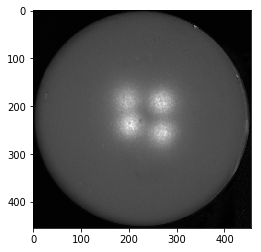

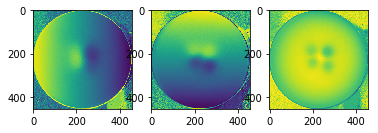

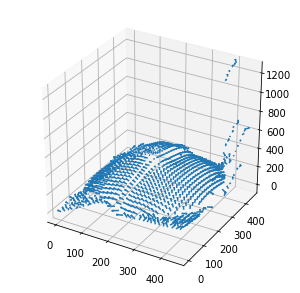

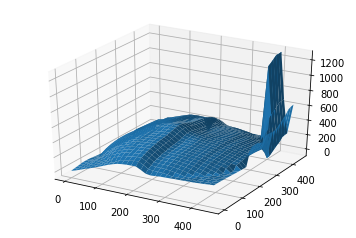

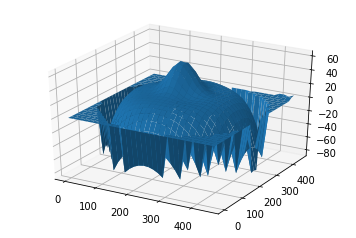

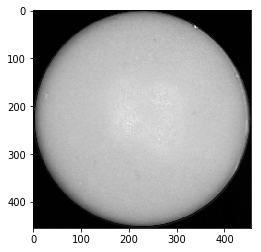

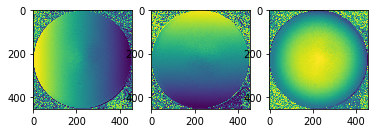

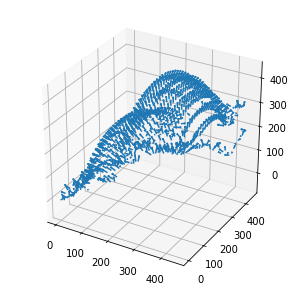

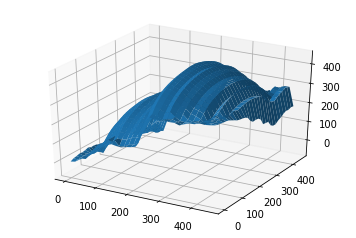

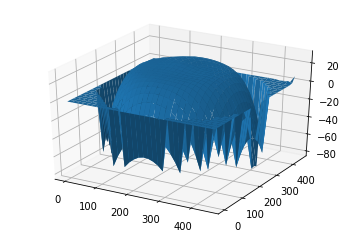

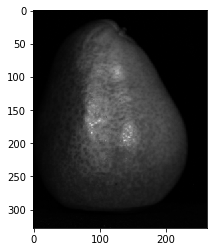

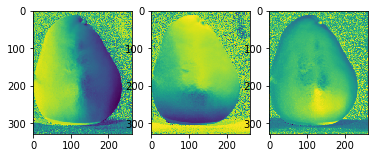

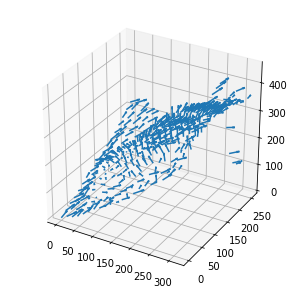

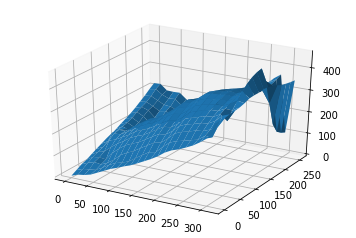

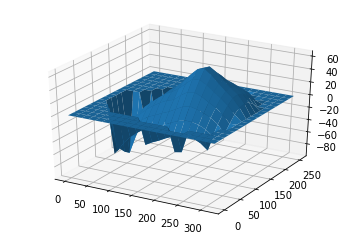

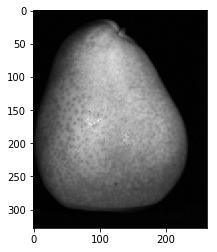

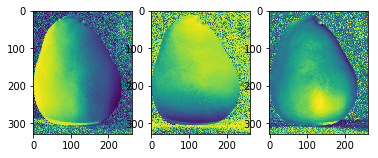

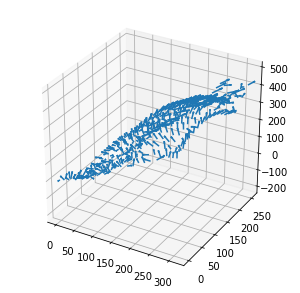

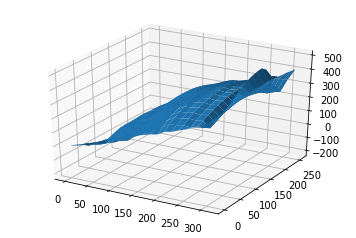

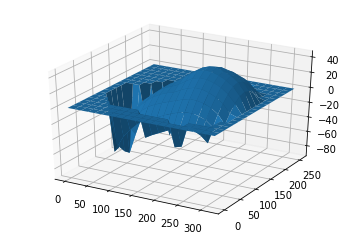

In [691]:
# ---------------------------------------------------------------------------
# You may reuse the code for photometric_stereo here.
# Write your code below to process the data and send it to photometric_stereo
# and display the albedo, normals and depth maps.
# ---------------------------------------------------------------------------

def f(data, option):
    rot_vec = np.hstack((data["c"][0][0],
                         data["c"][1][0],
                         data["c"][2][0]))
    xlen = data["im1"].shape[0]
    ylen = data["im1"].shape[1]
    images = []
    for i in range(1,5):
        if option == "diffuse":
            S, G = RGBToSUV(data["im"+str(i)], rot_vec)
            images.append(G/255)
        elif option == "original":
            rgb_image = data["im"+str(i)]
            gray_image = np.zeros((xlen, ylen))
            for x in range(xlen):
                for y in range(ylen):
                    gray_image[x][y] = 0.2989 * rgb_image[x][y][0] + 0.5870 * rgb_image[x][y][1] + 0.1140 * rgb_image[x][y][2]
            images.append(gray_image)
    images = np.array(images)
    lights = np.vstack((data["l1"], data["l2"], data["l3"], data["l4"]))
    mask = np.ones((xlen, ylen))
    tmp_mask = np.zeros((xlen, ylen))
    #for x in range(xlen):
    #    mask[x][0] = 0
    #    mask[x][-1] = 0
    #for y in range(ylen):
    #    mask[0][y] = 0
    #    mask[-1][y] = 0
    for i in range(1,5):
        tmp_mask += data["im"+str(i)][:, :, 0] + data["im"+str(i)][:,:,1] + data["im"+str(i)][:,:,2]
    threshold = 0.005
    for x in range(xlen):
        for y in range(ylen):
            if tmp_mask[x][y] < threshold:
                mask[x][y] = 0
    
    albedo, normals, depth, horn = photometric_stereo(images, lights, mask)

    # Stride in the plot, you may want to adjust it to different images
    stride = 15
    
    # showing albedo map
    fig = plt.figure()
    albedo_max = albedo.max()
    albedo = albedo / albedo_max
    plt.imshow(albedo, cmap="gray")
    plt.show()
    
    # showing normals as three separate channels
    figure = plt.figure()
    ax1 = figure.add_subplot(131)
    ax1.imshow(normals[..., 0])
    ax2 = figure.add_subplot(132)
    ax2.imshow(normals[..., 1])
    ax3 = figure.add_subplot(133)
    ax3.imshow(normals[..., 2])
    plt.show()

    # showing normals as quiver
    X, Y, _ = np.meshgrid(np.arange(0,np.shape(normals)[0], 15),
                          np.arange(0,np.shape(normals)[1], 15),
                          np.arange(1))
    X = X[..., 0]
    Y = Y[..., 0]
    Z = depth[::stride,::stride].T
    NX = normals[..., 0][::stride,::-stride].T
    NY = normals[..., 1][::-stride,::stride].T
    NZ = normals[..., 2][::stride,::stride].T
    fig = plt.figure(figsize=(5, 5))
    ax = fig.gca(projection='3d')
    # plt.quiver(X,Y,Z,NX,NY,NZ, length=0.02)
    plt.quiver(X,Y,Z,NX,NY,NZ, length=20)
    plt.show()
    
    # plotting wireframe depth map
    H = depth[::stride,::stride]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X,Y, H.T)
    plt.show()
    
    H = horn[::stride,::stride]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X,Y, H.T)
    plt.show()
    
    return normals, mask
    
    
normals_sphere_original, mask_sphere = f(data_sphere, "original")    
normals_sphere_diffuse,  mask_sphere = f(data_sphere, "diffuse")
normals_pear_original,   mask_pear   = f(data_pear, "original")
normals_pear_diffuse,    mask_pear   = f(data_pear, "diffuse")

## Surface Rendering 


### Lambertian Illumination

One of the simplest models available to render 3D objections with illumination is the Lambertian model. This
model finds the apparent brightness to an observer using the direction of the light source $\mathbf{L}$ and the normal
vector on the surface of the object $\mathbf{N}$. The brightness intensity at a given point on an object’s surface, $\mathbf{I_d}$, with
a single light source is found using the following relationship:

$$\mathbf{I_d} = \mathbf{L} \cdot \mathbf{N} (I_l\mathbf{C})$$

where, $\mathbf{C}$ and $I_l$ are the the color and intensity of the light source respectively.

### Phong Illumination

One major drawback of Lambertian illumination is that it only considers the diffuse light in its calculation of
brightness intensity. One other major component to illumination rendering is the specular component. The
specular reflectance is the component of light that is reflected in a single direction, as opposed to all directions,
which is the case in diffuse reflectance. One of the most used models to compute surface brightness with specular
components is the Phong illumination model. This model combines ambient lighting, diffused reflectance as well
as specular reflectance to find the brightness on a surface. Phong shading also considers the material in the scene
which is characterized by four values: the ambient reflection constant ($k_a$), the diffuse reflection constant ($k_d$),
the specular reflection constant ($k_s$) and $\alpha$ the Phong constant, which is the ‘shininess’ of an object. Furthermore,
since the specular component produces ‘rays’, only some of which would be observed by a single observer, the
observer’s viewing direction ($\mathbf{V}$) must also be known. For some scene with known material parameters with $M$
light sources the light intensity $\mathbf{I}_{phong}$ on a surface with normal vector $\mathbf{N}$ seen from viewing direction $\mathbf{V}$ can be
computed by:

$$\mathbf{I}_{phong} = k_{a}\mathbf{I}_{a} + \sum_{m\in M}\left\{k_d(\mathbf{L}_{m}\cdot\mathbf{N})\mathbf{I}_{m,d} + k_{s}(\mathbf{R}_{m}\cdot\mathbf{V})^{\alpha}\mathbf{I}_{m,s}\right\}\text{,}$$

$$\mathbf{R}_{m} = 2\mathbf{N}(\mathbf{L}_{m}\cdot\mathbf{N}) - \mathbf{L}_{m}\text{,}$$

where $\mathbf{I}_{a}$, is the color and intensity of the ambient lighting, $\mathbf{I}_{m,d}$ and $\mathbf{I}_{m,s}$ are the color values for the diffuse and
specular light of the $m$th light source.



Table 1: Light Sources

| $m$ | Location | Color (RGB)  |
| - | ----------- | ----- |
| 1 | $(-\tfrac{1}{3},\tfrac{1}{3},\tfrac{1}{3})^{\top}$ | $(1,1,1)$ |
| 2 | $(1,0,0)^{\top}$     | $(1,.5,.5)$ |

Table 2: Material Coefficients

| Mat. | $k_a$ | $k_d$ | $k_s$ | $\alpha$ |
| - | -------- | ----- | ----- | -------- |
| 1 | $0$ | $0.1$ | $0.75$ | $5$ |
| 2 | $0$ | $0.5$ | $0.1$ | $5$ |
| 3 | $0$ | $0.5$ | $0.5$ | $10$ |

### Part 1. Lambertian model

In [695]:
def lambertian(normals, lights, color, intensity, mask):
    '''Your implementation'''
    xlen = normals.shape[0]
    ylen = normals.shape[1]
    image = np.zeros((xlen, ylen, 3))
    for x in range(xlen):
        for y in range(ylen):
            normal = np.matrix(normals[x][y]).T
            image[x][y] = (lights*normal) * intensity * color 
    
    for i in range(3):
        image[:,:,i] = np.multiply(image[:,:,i], mask)
    
    return image

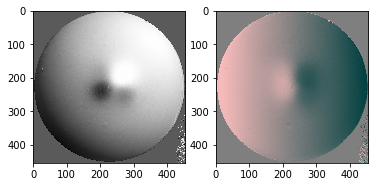

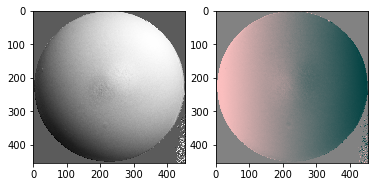

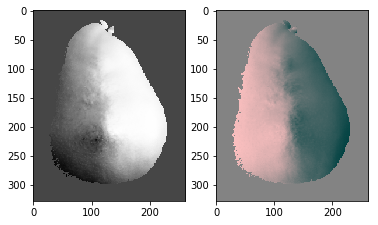

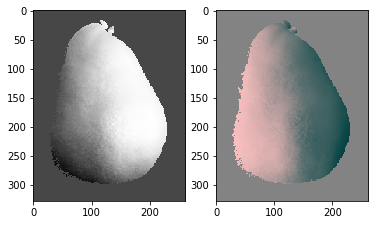

In [696]:
# Output the rendering results

light_color = []
light_color.append(np.matrix([1,1,1]))
light_color.append(np.matrix([1,.5,.5]))
light_loc = []
light_loc.append(np.array([-1/3, 1/3, 1/3]))
light_loc.append(np.array([1, 0, 0]))

normals_list = [normals_sphere_original, normals_sphere_diffuse, normals_pear_original, normals_pear_diffuse]
mask_list    = [mask_sphere, mask_sphere, mask_pear, mask_pear]

for normals, mask in zip(normals_list, mask_list):
    for i in range(2):
        color = light_color[i]
        loc = light_loc[i]
        intensity = 1
        image = lambertian(normals, loc, color, intensity, mask)
        image = (image - image.min())/(image.max() - image.min())
        plt.subplot(121+i)
        plt.imshow(image)
    plt.show()


### Part 2. Phong model

In [697]:
def phong(normals, lights, color, material, view, mask):
    '''Your implementation'''
    ka, kd, ks, alpha = material
    xlen = normals.shape[0]
    ylen = normals.shape[1]
    image = np.zeros((xlen, ylen, 3))
    for x in range(xlen):
        for y in range(ylen):
            normal = np.matrix(normals[x][y]).T
            Rm = 2 * normal.T[0] * float(lights * normal) - lights 
            #image[x][y] += 0  # ka = 0
            image[x][y] += kd * float(lights*normal) * np.array(color)[0]
            image[x][y] += ks * (float(Rm * view.T)** alpha) * np.array(color)[0]
    
    for i in range(3):
        image[:,:,i] = np.multiply(image[:,:,i], mask)
        
    return image

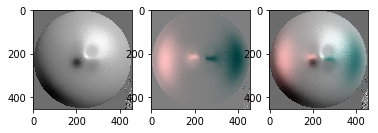

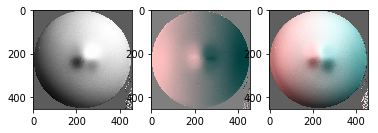

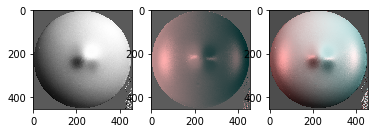

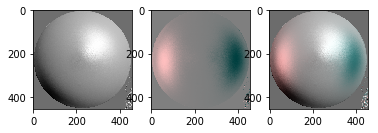

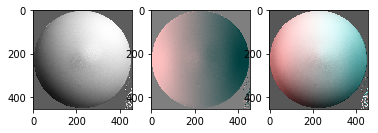

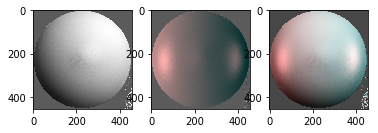

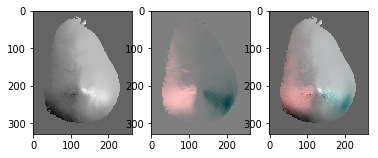

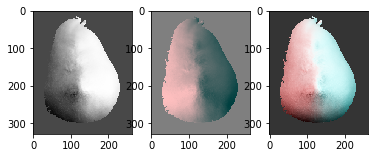

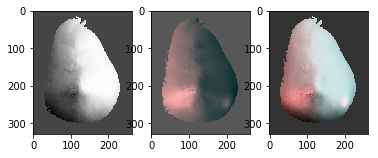

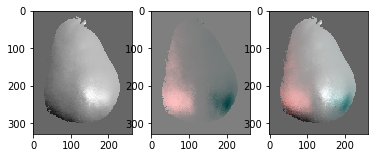

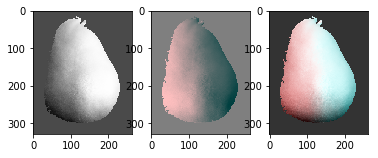

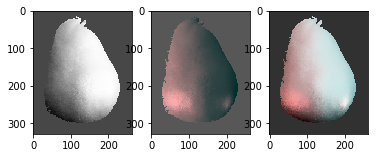

In [698]:
# Output the rendering results


#mat: ka, kd, ks, alpha
materials =[[ 0, 0.1, 0.75,  5 ],
      [0, 0.5, 0.1, 5],
      [0, 0.5, 0.5, 10]]
view = np.matrix([0,0,1])
#mask = None

for normals, mask in zip(normals_list, mask_list):
    for material in materials:
        xlen = normals.shape[0]
        ylen = normals.shape[1]
        image_total = np.zeros((xlen, ylen, 3))
        for i in range(2):
            color = light_color[i]
            loc = light_loc[i]
            image = phong(normals, loc, color, material, view, mask)
            image = (image - image.min())/(image.max() - image.min())
            plt.subplot(131+i)
            plt.imshow(image)
            image_total += image
        image_total = (image_total - image_total.min())/(image_total.max() - image_total.min())
        plt.subplot(133)
        plt.imshow(image_total)
        plt.show()